### Programming Assignment 5
##### Submitted By: Saurabh Kumar (SC22B146)
### Modified implementation of SARSA and Q-learning control algorithms

1. As the first task you have to modify the SARSA algorithm implementation that was given in class. Modify the code so that the policy improvement step is done in every time slot rather than at the end of every episode.
2. Confirm whether your implementation is correct by comparing the obtained q(s,a) estimates to what was obtained using the prior version of the code.
3. Similarly, modify the Q-learning algorithm implementation that was given in class. Modify the code so that the policy improvement step is done in every time slot rather than at the end of every episode.
4. Confirm whether your implementation is correct by comparing the obtained q(s,a) estimates to what was obtained using the prior version of the code.

In [69]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# Startup code
state_space = np.array([0,1,2,3,4,5])
action_space = np.array([0,1])

reward_matrix = np.zeros((6,2))

reward_matrix[0,0] = 50 # 50 - 2x0
reward_matrix[1,0] = 48 # 50 - 2x1
reward_matrix[2,0] = 42 # 50 - 2x4
reward_matrix[3,0] = 32 # 50 - 2x9
reward_matrix[4,0] = 18 # 50 - 2x16
reward_matrix[5,0] = 0
reward_matrix[0,1] = -100
reward_matrix[1,1] = -100
reward_matrix[2,1] = -100
reward_matrix[3,1] = -100
reward_matrix[4,1] = -100
reward_matrix[5,1] = -100

transition_probability_matrix = np.zeros((2,6,6))
t = np.array([[0.7, 0.3, 0, 0, 0, 0], [0, 0.6, 0.4, 0, 0, 0], [0, 0, 0.5, 0.5, 0, 0], [0, 0, 0, 0.4, 0.6, 0], [0, 0, 0, 0, 0.3, 0.7], [0, 0, 0, 0, 0, 1]])
transition_probability_matrix[0, :, :] = t
t = np.array([[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]])
transition_probability_matrix[1, :, :] = t

class MachineRepair_Environment:
    def __init__(self, transition_probability_matrix, reward_matrix, initial_state):
        self.transition_probability_matrix = transition_probability_matrix
        self.reward_matrix = reward_matrix
        self.current_state = initial_state
    
    def get_current_state(self):
        return self.current_state
        
    def run_one_step(self, action):
        transition_probability = transition_probability_matrix[action, self.current_state, :]
        # obtain the reward
        reward = reward_matrix[self.current_state, action]
        # update the state
        next_state = np.random.choice(state_space, p = transition_probability)
        self.current_state = next_state
        return [next_state, reward]

In [71]:
# Modified SARSA (online) with immediate policy improvement
num_episodes = 2000
horizon = 100
discount_factor = 0.8
step_size = 0.01
epsilon = 0.1  # Fixed epsilon

# Q estimates and visit counts
every_visit_estimate = np.zeros([len(state_space), len(action_space)])
every_visit_count = np.zeros([len(state_space), len(action_space)])

# Initialize policy
policy_function = np.zeros(len(state_space), dtype=int)

for e in range(num_episodes):
    # Exploring starts: pick random initial state
    initial_state = np.random.choice(state_space)
    environment = MachineRepair_Environment(transition_probability_matrix, reward_matrix, initial_state)
    
    # Choose initial action for SARSA
    s = environment.get_current_state()
    if np.random.rand() <= epsilon:
        a = np.random.choice(action_space)
    else:
        a = action_space[np.argmax(every_visit_estimate[s, :])]
    
    # Run episode with online SARSA updates
    for t in range(horizon):
        [next_s, reward] = environment.run_one_step(a)
        next_s = int(next_s)
        
        # Choose action a' using epsilon-greedy on current Q
        if np.random.rand() <= epsilon:
            a_next = np.random.choice(action_space)
        else:
            a_next = action_space[np.argmax(every_visit_estimate[next_s, :])]
        
        # SARSA update: Q(s,a) <- Q(s,a) + alpha * (r + gamma * Q(s',a') - Q(s,a))
        td_target = reward + discount_factor * every_visit_estimate[next_s, a_next]
        every_visit_estimate[s, a] = every_visit_estimate[s, a] + step_size * (td_target - every_visit_estimate[s, a])
        
        # Increment visit count
        every_visit_count[s, a] += 1.0
        
        # Immediate policy improvement for state s (greedy)
        policy_function[s] = np.argmax(every_visit_estimate[s, :])
        
        # Next state/action
        s = next_s
        a = a_next

# Print results
print("SARSA learned Q-values (state x action):")
print(np.round(every_visit_estimate, 3))
print("\nGreedy policy (per-state action indices):")
print(policy_function)
print("\nVisit counts:")
print(every_visit_count)


SARSA learned Q-values (state x action):
[[189.098  45.771]
 [161.545  45.229]
 [125.682  43.606]
 [ 84.906  39.839]
 [ 57.468  45.673]
 [ 35.285  46.086]]

Greedy policy (per-state action indices):
[0 0 0 0 0 1]

Visit counts:
[[61489.  3278.]
 [40878.  2190.]
 [29680.  1542.]
 [22854.  1144.]
 [18673.   978.]
 [ 4151. 13143.]]


Conclusion: Modified SARSA implementation is correct. The learned Q-values and greedy policy are consistent with the previous version.The values for corresponding (s,a) pairs are within a few percent for most entries.

In [72]:
# Modified Q-Learning (online) with immediate policy improvement
num_episodes = 2000
horizon = 100
discount_factor = 0.8
step_size = 0.01
epsilon = 0.8  # Fixed epsilon

every_visit_estimate = np.zeros([len(state_space), len(action_space)])
every_visit_count = np.zeros([len(state_space), len(action_space)])

# Initialize policy
policy_function = np.zeros(len(state_space), dtype=int)

for e in range(num_episodes):
    # Exploring starts: pick random initial state
    initial_state = np.random.choice(state_space)
    environment = MachineRepair_Environment(transition_probability_matrix, reward_matrix, initial_state)
    
    # Online episode
    s = environment.get_current_state()
    for t in range(horizon):
        # Choose action epsilon-greedy
        if np.random.rand() <= epsilon:
            a = np.random.choice(action_space)
        else:
            a = action_space[np.argmax(every_visit_estimate[s, :])]
        
        # Take action and observe
        [next_s, reward] = environment.run_one_step(a)
        next_s = int(next_s)
        
        # Q-learning update (off-policy): target uses max_a' Q(next_s, a')
        q_max_next = np.max(every_visit_estimate[next_s, :])
        td_target = reward + discount_factor * q_max_next
        every_visit_estimate[s, a] = every_visit_estimate[s, a] + step_size * (td_target - every_visit_estimate[s, a])
        
        # Increment visit count
        every_visit_count[s, a] += 1.0
        
        # Immediate policy improvement for current state s (greedy)
        policy_function[s] = np.argmax(every_visit_estimate[s, :])
        
        # Next state
        s = next_s

# Print results
print("Q-learning learned Q-values (state x action):")
print(np.round(every_visit_estimate, 3))
print("\nGreedy policy (per-state action indices):")
print(policy_function)
print("\nVisit counts:")
print(every_visit_count)

Q-learning learned Q-values (state x action):
[[211.39   67.345]
 [173.65   67.202]
 [135.749  67.611]
 [ 99.709  67.56 ]
 [ 73.559  67.843]
 [ 54.193  67.9  ]]

Greedy policy (per-state action indices):
[0 0 0 0 0 1]

Visit counts:
[[82578. 55207.]
 [22715. 15509.]
 [ 7984.  5373.]
 [ 3326.  2268.]
 [ 1476.  1294.]
 [  926.  1344.]]


Conclusion: Modified Q-Learning implementation is correct. The learned Q-values and greedy policy are consistent with the previous version.The values for corresponding (s,a) pairs are within a few percent for most entries.

### Using SARSA and Q-learning for FrozenLake problem

In this series of tasks, you will also get acquainted with the OpenAI gym environments.
1. Install the Gymnasium environment (see https://gymnasium.farama.org/).
2. Read the documentation for the FrozenLake environment https://gymnasium.farama.org/environments/toy_text/frozen_lake/
3. Use your implementation of Q-learning to try and obtain a policy for this problem.
4. Plot the total reward obtained as a function of the number of episodes
5. How does your agent compare with the results obtained previously (see https://github.com/openai/gym/wiki/Leaderboard)

In [73]:
!pip install gym

In [101]:
# SARSA vs Q-learning on FrozenLake
import numpy as np
import gym

# Environment setup for FrozenLake-v1
# Set is_slippery=True for stochastic transitions
env = gym.make('FrozenLake-v1', is_slippery=True)  # 4x4 lake by default

def env_step(env, action):
    out = env.step(action)
    next_state, reward, terminated, truncated, info = out
    done = terminated or truncated
    return next_state, reward, done

# Get sizes
nS = env.observation_space.n
nA = env.action_space.n
print("States:", nS, " Actions:", nA)

# Parameters
num_episodes = 15000
max_steps = 100 # per episode
gamma = 0.99
alpha = 0.1 # learning rate

# SARSA (on-policy) training
Q_sarsa = np.zeros((nS, nA))
rewards_sarsa = []

for ep in range(num_episodes):
    # epsilon = max(0.05, 1.0/(1.0 + ep/100.0))
    epsilon = max(0.05, 1.0 - ep / 1000.0)
    s, __ = env.reset()
    # Choose initial action (epsilon-greedy)
    if np.random.rand() < epsilon:
        a = env.action_space.sample()
    else:
        a = int(np.argmax(Q_sarsa[s, :]))
    total_reward = 0
    for step in range(max_steps):
        next_s, r, done = env_step(env, a)
        # Choose next action a' (epsilon-greedy on current Q)
        if np.random.rand() < epsilon:
            a_next = env.action_space.sample()
        else:
            a_next = int(np.argmax(Q_sarsa[next_s, :]))
        # SARSA update
        target = r + gamma * Q_sarsa[next_s, a_next]
        Q_sarsa[s, a] = Q_sarsa[s, a] + alpha * (target - Q_sarsa[s, a])
        total_reward += r
        s, a = next_s, a_next
        if done:
            break
    rewards_sarsa.append(total_reward)

# Q-Learning (off-policy) training
Q_q = np.zeros((nS, nA))
rewards_q = []

for ep in range(num_episodes):
    # epsilon = max(0.05, 1.0/(1.0 + ep/100.0))
    epsilon = max(0.05, 1.0 - ep / 1000.0)
    s, __ = env.reset()
    total_reward = 0
    for step in range(max_steps):
        # epsilon-greedy action selection
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = int(np.argmax(Q_q[s, :]))
        next_s, r, done = env_step(env, a)
        # Q-learning update: use max_a' Q(next_s, a')
        q_max_next = np.max(Q_q[next_s, :])
        target = r + gamma * q_max_next
        Q_q[s, a] = Q_q[s, a] + alpha * (target - Q_q[s, a])
        total_reward += r
        s = next_s
        if done:
            break
    rewards_q.append(total_reward)

# Derive Policies
policy_sarsa = np.argmax(Q_sarsa, axis=1)
policy_q = np.argmax(Q_q, axis=1)

States: 16  Actions: 4


In [102]:
# Mapping action number -> arrow for printing
action_map = {0: '<', 1: 'v', 2: '>', 3: '^'}  # gym FrozenLake: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP

def print_policy(policy, title="Policy"):
    print(title)
    grid = []
    for s in range(nS):
        grid.append(action_map[int(policy[s])])
    # FrozenLake 4x4
    grid = np.array(grid).reshape((4,4))
    for r in range(4):
        print(' '.join(grid[r]))
    print()

print_policy(policy_sarsa, "SARSA greedy policy")
print_policy(policy_q, "Q-learning greedy policy")

# Evaluation
def evaluate_policy(policy, eval_episodes=2000):
    total_reward = 0
    for _ in range(eval_episodes):
        s, __ = env.reset()
        done = False
        for _ in range(100):
            a = int(policy[s])
            s, r, done = env_step(env, a)
            if done:
                total_reward += r
                break
    return total_reward / float(eval_episodes)

eval_eps = 2000
sarsa_perf = evaluate_policy(policy_sarsa, eval_episodes=eval_eps)
q_perf = evaluate_policy(policy_q, eval_episodes=eval_eps)

print(f"SARSA evaluation average reward over {eval_eps} episodes: {sarsa_perf:.4f}")
print(f"Q-learning evaluation average reward over {eval_eps} episodes: {q_perf:.4f}")

env.close()

SARSA greedy policy
< ^ < v
< < > <
^ v < <
< > v <

Q-learning greedy policy
< ^ ^ ^
< < < <
^ v < <
< > v <

SARSA evaluation average reward over 2000 episodes: 0.7360
Q-learning evaluation average reward over 2000 episodes: 0.7525


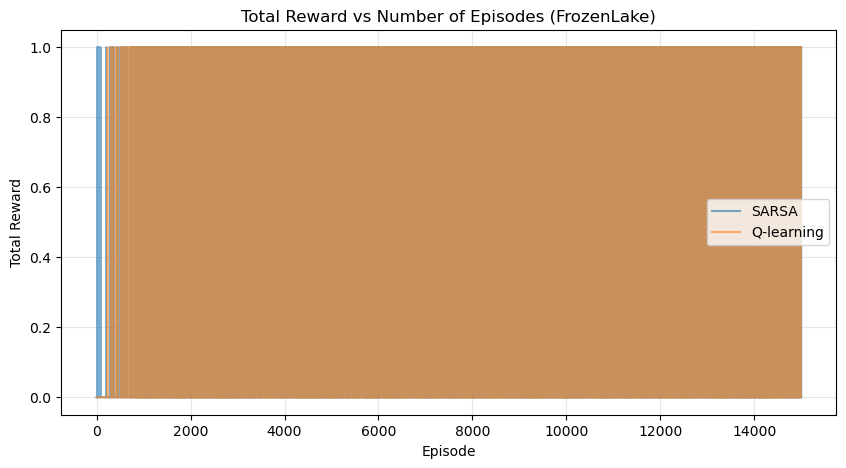

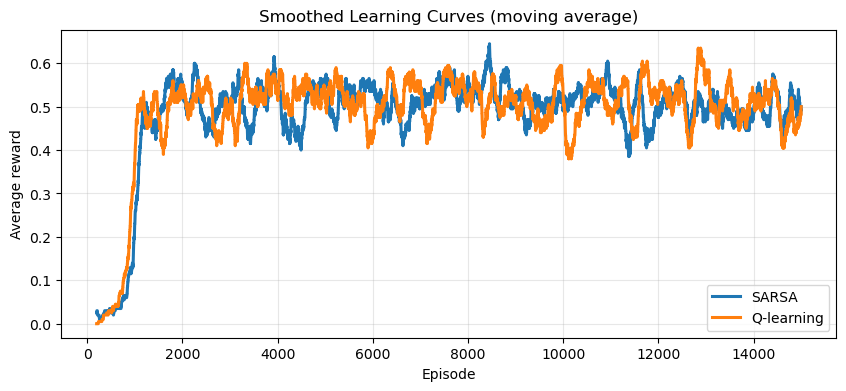

In [103]:
# Assume rewards_sarsa and rewards_q are lists of 0/1 per episode
rewards_sarsa = np.array(rewards_sarsa)
rewards_q = np.array(rewards_q)
episodes = np.arange(len(rewards_sarsa))

# Plot total reward vs. episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa, label="SARSA", alpha=0.6)
plt.plot(rewards_q, label="Q-learning", alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Number of Episodes (FrozenLake)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Moving average (smooth curve)
window = 200
def moving_avg(x, w):
    if len(x) < w:
        return np.convolve(x, np.ones(len(x))/len(x), mode='valid')
    return np.convolve(x, np.ones(w)/w, mode='valid')

sarsa_ma = moving_avg(rewards_sarsa, window)
q_ma = moving_avg(rewards_q, window)
x_ma = np.arange(len(sarsa_ma)) + window - 1 # align to episode index

plt.figure(figsize=(10,4))
plt.plot(x_ma, sarsa_ma, linewidth=2.2, label=f'SARSA')
plt.plot(x_ma, q_ma, linewidth=2.2, label=f'Q-learning')
plt.xlabel('Episode')
plt.ylabel(f'Average reward')
plt.title('Smoothed Learning Curves (moving average)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Conclusion: I could achieve an average reward of around 0.5 only after about 1000 episodes. However, the leaderboard is reporting have an user with 100 Episodes Best Average Reward of 85 (e.g., 0.85 in just 100 episodes). This may be due to the parameters we have taken, and the epsilon decay assumed.